In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import random

from typing import List, Dict, Tuple, Callable

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
INPUT_SIZE = (299, 299)

In [4]:
dataset_dir = "emotions_ds"

In [5]:
def get_classes(path: str) -> Dict:
    classes = os.listdir(os.path.join(path, "train_class"))
    classes = {index: cls for index, cls in enumerate(classes)}
    return classes

classes = get_classes(dataset_dir)
classes

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [6]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "test": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

In [7]:
batch_train = 128
batch_test = 32
shuffle = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class:  neutral


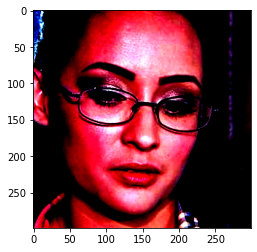

In [8]:
train_data = datasets.ImageFolder(root=os.path.join(dataset_dir, "train_class"), transform=data_transforms["train"])
test_data = datasets.ImageFolder(root=os.path.join(dataset_dir, "val_class"), transform=data_transforms["test"])

im, label = train_data[random.randint(0, len(train_data))]

print("Class: ", classes[label])
plt.imshow(im.permute(1,2,0).cpu())
plt.show()

dataloaders = {
    "train": DataLoader(train_data, batch_size=batch_train, shuffle=shuffle, drop_last=True),
    "test": DataLoader(test_data, batch_size=batch_test, shuffle=shuffle, drop_last=True),
}

In [9]:
feature_extracting = True
input_shape = (3, 299, 299)

In [10]:
from torchsummary import summary

def load_model(num_classes: int, feature_extracting: bool) -> Tuple:
    model = torchvision.models.inception_v3(pretrained=True)

    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

    num_fltrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(num_fltrs, 128),
                             nn.ReLU(),
                             nn.Linear(128, num_classes),
                             nn.Softmax(dim=1))

    model.aux_logits = False

    criter = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=0.001)

    return model.to(device), criter, opt

model, criterion, optimizer = load_model(len(classes), feature_extracting)

summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [11]:
def train_batch(X: torch.Tensor,
                y: torch.Tensor,
                model: nn.Module,
                criter: Callable[[torch.Tensor, torch.Tensor], float],
                optimizer:  optim.Optimizer) -> float:

    output = model(X)

    loss = criter(output, y)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    return loss.item()


@torch.no_grad()
def accuracy(X: torch.Tensor, y: torch.Tensor, model: nn.Module) -> float:
    model.eval()
    output = model(X)
    _, preds = torch.max(output, dim=1)
    correct = (preds == y).float().sum()
    return correct.item()

In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.1.weight
fc.1.bias
fc.3.weight
fc.3.bias


In [13]:
epochs = 3

In [14]:
def train_model(model: nn.Module,
                dataloaders: Dict[str, DataLoader],
                epochs: int,
                criter: Callable[[torch.Tensor, torch.Tensor], float],
                optimizer: optim.Optimizer) -> Tuple:

    train_acc, train_loss = [], []
    test_acc= []

    for epoch in range(epochs):
        print("Epoch {} / {}: ".format(epoch + 1, epochs))
        for phase in ["train", "test"]:
            print("Phase: ", phase)
            current_loss = 0
            current_correct = 0

            if phase == "train":
                model.train()
                for batch, (X, y) in enumerate(dataloaders[phase]):
                    
                    X, y = X.to(device), y.to(device)

                    batch_loss = train_batch(X, y, model, criter, optimizer)
                    correct = accuracy(X, y, model)

                    current_loss += batch_loss
                    current_correct += correct
                    

                epoch_loss = current_loss / len(dataloaders[phase])
                print(current_correct)
                epoch_acc = current_correct / len(train_data)

                
                print("Loss: {:.3f}, Accuracy: {:.3f}".format(epoch_loss, epoch_acc))

                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            if phase == "test":
            
                with torch.no_grad():
                    for X, y in dataloaders[phase]:
                     
                        X, y = X.to(device), y.to(device)
                        
                        correct = accuracy(X, y, model)

                        current_correct += correct


                    epoch_acc = current_correct / len(test_data)

                    print("Accuracy: {:.3f}".format(epoch_acc))
                    
                    test_acc.append(epoch_acc)


    torch.save(model, "models/EmotionsModel.pt")
    return train_acc, train_loss, test_acc


train_acc, train_loss, test_acc = train_model(model, dataloaders, epochs, criterion, optimizer)

Epoch 1 / 3: 
Phase:  train
10287.0
Loss: 1.991, Accuracy: 0.274
Phase:  test
Accuracy: 0.285
Epoch 2 / 3: 
Phase:  train
12442.0
Loss: 1.941, Accuracy: 0.331
Phase:  test
Accuracy: 0.311
Epoch 3 / 3: 
Phase:  train
13195.0
Loss: 1.922, Accuracy: 0.351
Phase:  test
Accuracy: 0.316


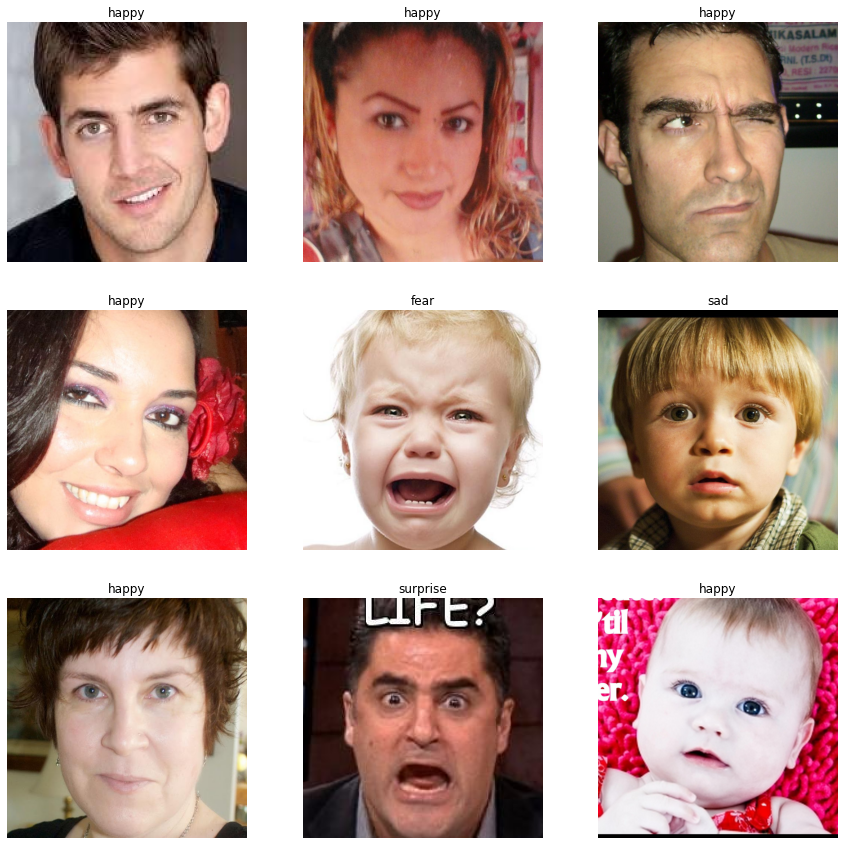

In [16]:
def predict(img: Image) -> int:
    from torch.autograd import Variable

    img = data_transforms["test"](img)
    img = img.unsqueeze(0).cuda()
    img = Variable(img).to(device)

    pred = model(img)
    cls = pred.data.cpu().numpy().argmax()
    return cls


def predict_k_images(imgs_paths: List, size: int) -> None:
    fig = plt.figure(figsize=(15, 15))

    imgs = random.sample(imgs_paths, size * size)

    for i in range(size * size):
        img = Image.open(imgs[i])
        index = predict(img)
        plt.subplot(size, size, i+1)
        plt.title(classes[index])
        plt.axis('off')
        plt.imshow(img)


model = torch.load("models/EmotionsModel.pt")
model.eval()

images_dir = "emotions_ds/val_class"
dirs = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]
pred_images = []
for d in dirs:
    pred_images.extend([os.path.join(d, f) for f in os.listdir(d)])

predict_k_images(pred_images, 3)

In [17]:
all_folders = {f:os.path.join(images_dir, f) for f in os.listdir(images_dir)}
all_folders

{'anger': 'emotions_ds/val_class\\anger',
 'contempt': 'emotions_ds/val_class\\contempt',
 'disgust': 'emotions_ds/val_class\\disgust',
 'fear': 'emotions_ds/val_class\\fear',
 'happy': 'emotions_ds/val_class\\happy',
 'neutral': 'emotions_ds/val_class\\neutral',
 'sad': 'emotions_ds/val_class\\sad',
 'surprise': 'emotions_ds/val_class\\surprise'}

In [18]:
predictions_classes = {cls: np.array([]) for cls in all_folders.keys()}


def get_all_predictions(cls: str) -> np.ndarray:
    path = os.path.join(images_dir, cls)
    imgs = [os.path.join(path, f) for f in os.listdir(path)]

    preds = []
    for img in imgs:
        img = Image.open(img)
        preds.append(predict(img))

    return np.array(preds)

for k in predictions_classes.keys():
    predictions_classes[k] = get_all_predictions(k)

In [19]:
predictions_classes

{'anger': array([0, 4, 0, 0, 4, 0, 7, 0, 5, 6, 4, 0, 0, 5, 0, 6, 7, 0, 5, 0, 3, 3,
        4, 4, 6, 4, 6, 6, 3, 5, 5, 4, 4, 5, 5, 5, 6, 0, 0, 0, 6, 5, 7, 6,
        6, 5, 3, 5, 5, 6, 0, 0, 4, 7, 6, 7, 0, 0, 0, 0, 0, 5, 0, 5, 1, 1,
        4, 1, 3, 3, 1, 4, 5, 6, 3, 0, 6, 5, 0, 0, 7, 0, 0, 6, 6, 0, 0, 4,
        4, 4, 0, 5, 0, 0, 0, 5, 6, 5, 5, 4, 4, 7, 0, 0, 6, 5, 0, 5, 6, 0,
        1, 0, 6, 0, 0, 5, 0, 0, 3, 5, 7, 0, 0, 1, 4, 0, 0, 6, 0, 0, 0, 6,
        0, 5, 5, 5, 1, 0, 5, 5, 6, 6, 6, 5, 7, 6, 0, 0, 0, 6, 6, 3, 5, 5,
        3, 6, 3, 6, 0, 0, 4, 0, 0, 6, 0, 0, 0, 3, 3, 6, 4, 3, 6, 0, 5, 0,
        5, 6, 0, 0, 3, 0, 7, 7, 6, 6, 5, 5, 5, 3, 1, 5, 6, 4, 3, 0, 0, 3,
        4, 3, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 1, 6, 5, 6, 5, 7, 0, 5, 0, 7,
        5, 0, 0, 0, 0, 5, 0, 0, 7, 0, 0, 0, 3, 5, 7, 0, 0, 6, 0, 6, 3, 6,
        4, 3, 0, 3, 0, 6, 3, 0, 0, 0, 5, 6, 4, 5, 0, 6, 0, 5, 3, 6, 6, 3,
        6, 4, 5, 0, 0, 0, 6, 6, 5, 4, 0, 0, 0, 5, 0, 4, 0, 3, 7, 0, 6, 0,
        0, 4, 0, 5, 6, 5, 0, 

In [20]:
predictions_list = np.array([])
for v in predictions_classes.values():
    predictions_list = np.append(predictions_list, v)

predictions_list.shape

(4000,)

In [21]:
reverse_emotion_classes = {v: k for k, v in classes.items()}
reverse_emotion_classes

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [22]:
true_labels = np.array([])

for cls in all_folders.keys():
    d = os.path.join(images_dir, cls)
    labels = [reverse_emotion_classes[cls] for f in os.listdir(d)]
    true_labels = np.append(true_labels, labels)

true_labels.shape

(4000,)

In [23]:
print(predictions_list.dtype)

float64


In [24]:
print(true_labels.dtype)

float64


In [25]:
from sklearn.metrics import classification_report

print(classification_report(predictions_list, true_labels, target_names=list(reverse_emotion_classes.keys())))

              precision    recall  f1-score   support

       anger       0.38      0.28      0.33       675
    contempt       0.19      0.35      0.24       269
     disgust       0.00      0.00      0.00         0
        fear       0.43      0.39      0.41       552
       happy       0.59      0.35      0.44       842
     neutral       0.41      0.26      0.32       787
         sad       0.30      0.27      0.28       554
    surprise       0.22      0.35      0.27       321

    accuracy                           0.32      4000
   macro avg       0.32      0.28      0.29      4000
weighted avg       0.40      0.32      0.35      4000



<AxesSubplot:>

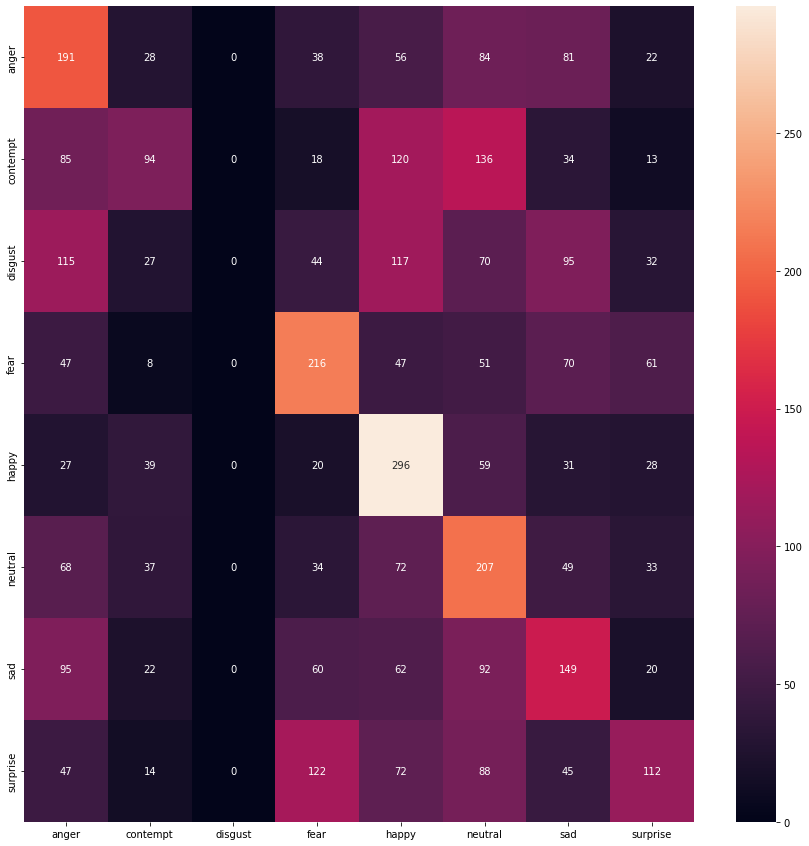

In [26]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

confusion = confusion_matrix(true_labels, predictions_list)

fig = plt.figure(figsize=(15, 15))
heatmap(confusion,
        annot=True,
        fmt="d",
        xticklabels=list(reverse_emotion_classes.keys()),
        yticklabels=list(reverse_emotion_classes.keys()))

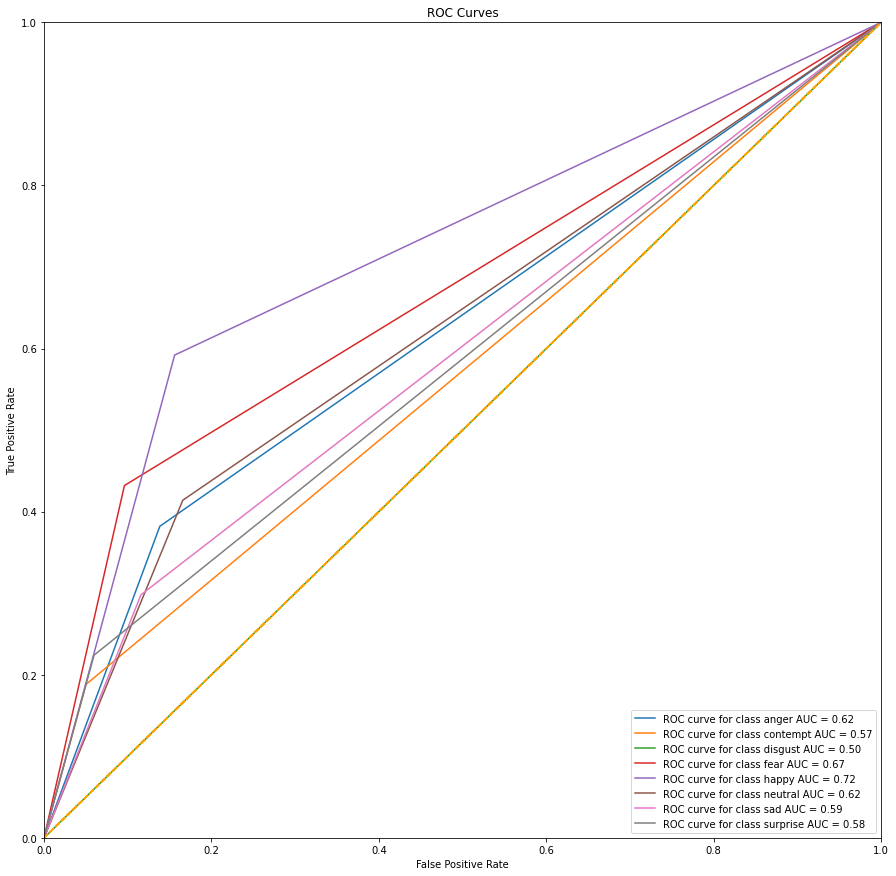

In [27]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(15, 15))

def plot_roc_curves(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    true_for_class = [(y_true == float(i)) for i in list(classes.keys())]
    pred_for_class = [(y_pred == float(i)) for i in list(classes.keys())]
    
    fpr_tpr = [roc_curve(true_for_class[i], pred_for_class[i]) for i in list(classes.keys())]
    roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in list(classes.keys())]
    
    plt.title("ROC Curves")
    
    for i in list(classes.keys()):
        plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label="ROC curve for class {} AUC = {:0.2f}".format(classes[i], roc_auc[i]))
        plt.legend(loc="lower right")
        plt.plot([0,1], [0,1], color='orange', linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")

    plt.show()
        

plot_roc_curves(true_labels, predictions_list)